<a href="https://colab.research.google.com/github/entruv/code_stream/blob/master/chess/03_11_2020_Utiliser_Recherche_d'arbre_echecs_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Recapitulatif de l'avancement pour l'IA des echecs

Lien du precedent notebook:
https://github.com/entruv/code_stream/blob/master/chess/03-10-2020%20Small%20Model%20learn%20legal%20moves%20chess.ipynb

- [x] Avoir un modele qui peut predire des probabilites pour chaque coup, et estimer qui a l'avantage dans une position d'echecs
- [ ] simuler une partie d'echecs, cela va creer un Arbre ou les noeuds sont des positions d'echecs
- [ ] sauvegarder les resultats de cette simulation et entrainer le modele a predire qui avait l'avantage, sans faire de simulation

In [0]:
import chess
import numpy as np



## Helper fonctions: Generer la liste des coups aux echecs

In [0]:
def create_uci_labels():
    """
    Creates the labels for the universal chess interface into an array and returns them
    :return:
    """
    labels_array = []
    letters = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h'] #indice colonnes echiquier
    numbers = ['1', '2', '3', '4', '5', '6', '7', '8'] #indice lignes echiquier
    promoted_to = ['q', 'r', 'b', 'n'] #list of the available promotion for the pawn

    for l1 in range(8):
        for n1 in range(8):
            destinations = [(t, n1) for t in range(8)] + \
                           [(l1, t) for t in range(8)] + \
                           [(l1 + t, n1 + t) for t in range(-7, 8)] + \
                           [(l1 + t, n1 - t) for t in range(-7, 8)] + \
                           [(l1 + a, n1 + b) for (a, b) in
                            [(-2, -1), (-1, -2), (-2, 1), (1, -2), (2, -1), (-1, 2), (2, 1), (1, 2)]]
            for (l2, n2) in destinations:
                if (l1, n1) != (l2, n2) and l2 in range(8) and n2 in range(8):
                    move = letters[l1] + numbers[n1] + letters[l2] + numbers[n2]
                    labels_array.append(move)
    for l1 in range(8):
        l = letters[l1]
        for p in promoted_to:
            labels_array.append(l + '2' + l + '1' + p)
            labels_array.append(l + '7' + l + '8' + p)
            if l1 > 0:
                l_l = letters[l1 - 1]
                labels_array.append(l + '2' + l_l + '1' + p)
                labels_array.append(l + '7' + l_l + '8' + p)
            if l1 < 7:
                l_r = letters[l1 + 1]
                labels_array.append(l + '2' + l_r + '1' + p)
                labels_array.append(l + '7' + l_r + '8' + p)
    return labels_array
all_moves = create_uci_labels()

## Node definition: Chess Board

In [0]:
from abc import ABC, abstractmethod
from collections import defaultdict
import math
import copy #permet de copier un objet proprement

class BoardAi(chess.Board):
    """
    A representation of a single board state.
    MCTS works by constructing a tree of these Nodes.
    Could be e.g. a chess or checkers board state.
    """

    # def copy(self):
    #   return copy.copy(self)

    def get_numpy_board(self):
      def transform_line(line):
          result = ""
          for character in line:
              if character.isdigit():
                  for i in range(int(character)):
                      result += "1"
              else:
                  result += character
          return result
      
      def compute_en_passant(ep_square):
          def alg_to_coord(alg):
              rank = 8 - int(alg[1])        # 0-7
              file = ord(alg[0]) - ord('a') # 0-7 #WTF ord("a")??
              return rank, file
          # renvoie une matrice de la taille dun jeu d'echec, contenant True si la case possede un 
          #pion que l'on peut manger en passant
          en_passant = np.zeros((8, 8, 1), dtype=np.bool)
          if ep_square != '-':
              eps = alg_to_coord(ep_square)
              en_passant[eps[0]][eps[1]] = True
          return en_passant

      fen_data = self.fen().split(" ")
      fen, turn, castling, ep_square, half_move_clock, fullmove_number = fen_data
      en_passant = compute_en_passant(ep_square)
      auxiliary_planes = [np.full((8, 8, 1), ('K' in castling), dtype=np.bool),
                          np.full((8, 8, 1), ('Q' in castling), dtype=np.bool),
                          np.full((8, 8, 1), ('k' in castling), dtype=np.bool),
                          np.full((8, 8, 1), ('q' in castling), dtype=np.bool),
                          en_passant]
      
      piece_information_plane = np.zeros((8,8, len(one_hot_dictionary)))
      for i, line in enumerate(fen.split("/")):
          for j, case in enumerate(transform_line(line)):
              piece_information_plane[i][j] = one_hot_dictionary[case]    
      all_planes = auxiliary_planes + [piece_information_plane]
      all_planes_numpy = np.concatenate(all_planes, axis=-1).astype(np.float32)
      return all_planes_numpy

    def find_legal_moves(self):
      return list(self.legal_moves)
  
    def find_children(self):
      "All possible successors of this board state"
      childrens = []
      for move in self.find_legal_moves():
          board = self.copy()
          board.push(move)
          childrens.append(board)
      return childrens

    def find_random_child(self):
      childrens = self.find_children()
      if childrens:
        return np.random.choice(childrens)
        "Random successor of this board state (for more efficient simulation)"
      return None

    def is_terminal(self):
      # use the 50 move rule to stop the game accordingly
      return len(self.find_children()) == 0 or self.can_claim_draw()


    def get_reward(self, result):
      if result == "1-0":
          return 1
      if result == "0-1":
          return -1
      if result == "1/2-1/2":
          return 0 #biais pour explorer les parties qui ne rendent pas un etat null
      return 0
    def reward(self):
      "Assumes `self` is terminal node."
      result = self.result() #vient de la classe parent chess.Board()
      print(f"Resultat de la partie: {result}")
      return self.get_reward(result)

    def identifier(self):
      return str(self.board_fen()) + str(self.turn) + str(self.castling_rights) + str(self.ep_square)
    
    def __hash__(self):
        "Nodes must be hashable"
        #permet de distinguer si deux noeuds sont identiques ou differents. Utile car mes noeuds sont des objets pythons difficile a comparer par nature
        return hash(self.identifier())
    
    def __eq__(node1, node2):
      return node1.identifier() == node2.identifier()

## MCTS algorithm 

In [0]:
class MCTS:
    "Monte Carlo tree searcher. First rollout the tree then choose a move."

    def __init__(self, exploration_weight=1):
        self.Q = defaultdict(int)  # total reward of each node
        self.N = defaultdict(int)  # total visit count for each node
        self.children = dict()  # children of each node
        self.exploration_weight = exploration_weight

    def choose(self, node):
        "Choose the best successor of node. (Choose a move in the game)"
        if node.is_terminal():
            raise RuntimeError(f"choose called on terminal node {node}")

        if node not in self.children:
            return node.find_random_child()

        def score(n):
            if self.N[n] == 0:
                return float("-inf")  # avoid unseen moves
            return self.Q[n] / self.N[n]  # average reward

        return max(self.children[node], key=score)

    def do_rollout(self, node):
        "Make the tree one layer better. (Train for one iteration.)"
        path = self._select(node)
        leaf = path[-1]
        self._expand(leaf)
        reward = self._simulate(leaf)
        self._backpropagate(path, reward)

    def _select(self, node):
        "Find an unexplored descendent of `node`"
        path = []
        while True:
            path.append(node)
            if node not in self.children or not self.children[node]:
                # node is either unexplored or terminal
                return path
            unexplored = self.children[node] - self.children.keys()
            if unexplored:
                n = unexplored.pop()
                path.append(n)
                return path
            node = self._uct_select(node)  # descend a layer deeper

    def _expand(self, node):
        "Update the `children` dict with the children of `node`"
        if node in self.children:
            return  # already expanded
        self.children[node] = node.find_children()

    def _simulate(self, node):
        "Returns the reward for a random simulation (to completion) of `node`"
        invert_reward = True
        while True:
            if node.is_terminal():
              reward = node.reward()
              return 1 - reward if invert_reward else reward
            node = node.find_random_child()
            invert_reward = not invert_reward

    def _backpropagate(self, path, reward):
        "Send the reward back up to the ancestors of the leaf"
        for node in reversed(path):
            self.N[node] += 1
            self.Q[node] += reward
            reward = 1 - reward  # 1 for me is 0 for my enemy, and vice versa


    def _uct_select(self, node):
        "Select a child of node, balancing exploration & exploitation"

        # All children of node should already be expanded:
        assert all(n in self.children for n in self.children[node])

        log_N_vertex = math.log(self.N[node])

        def uct(n):
            "Upper confidence bound for trees"
            return self.Q[n] / self.N[n] + self.exploration_weight * math.sqrt(
                log_N_vertex / self.N[n]
            )

        return max(self.children[node], key=uct)


In [0]:
%load_ext cython

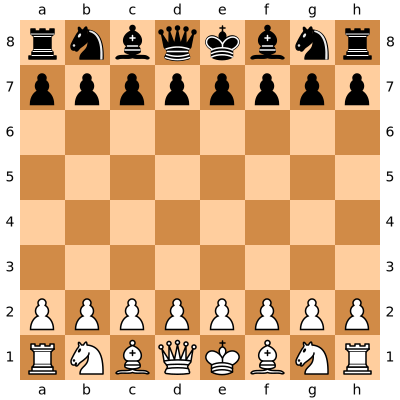

In [0]:
import chess
tree = MCTS()
board = BoardAi()
board

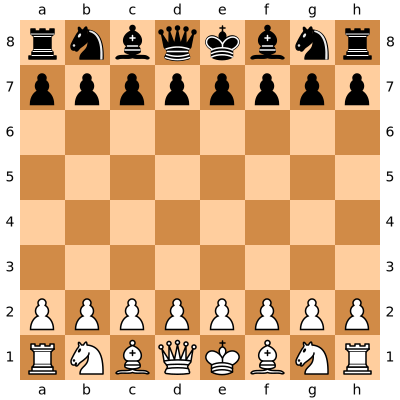

In [0]:
board

In [0]:
tree.do_rollout(board) #4secondes to simulate an entire game!!

terminal node has been found
Resultat de la partie: 1/2-1/2


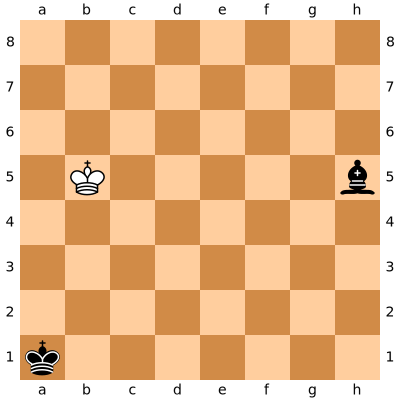

In [0]:
#visualisons le dernier coup:
BoardAi("8/8/8/1K5b/8/8/8/k7 b - - 99 215")

## Visualisation de Q et de N, et des poids d'exploration

In [72]:
tree.Q #represente score pour chaque position du jeu

defaultdict(int,
            {BoardAi('rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1'): 11,
             BoardAi('rnbqkbnr/pppppppp/8/8/8/7N/PPPPPPPP/RNBQKB1R b KQkq - 1 1'): 0,
             BoardAi('rnbqkbnr/pppppppp/8/8/8/7P/PPPPPPP1/RNBQKBNR b KQkq - 0 1'): 1,
             BoardAi('rnbqkbnr/pppppppp/8/8/8/6P1/PPPPPP1P/RNBQKBNR b KQkq - 0 1'): 1,
             BoardAi('rnbqkbnr/pppppppp/8/8/8/5N2/PPPPPPPP/RNBQKB1R b KQkq - 1 1'): 0,
             BoardAi('rnbqkbnr/pppppppp/8/8/8/5P2/PPPPP1PP/RNBQKBNR b KQkq - 0 1'): 0,
             BoardAi('rnbqkbnr/pppppppp/8/8/8/4P3/PPPP1PPP/RNBQKBNR b KQkq - 0 1'): 0,
             BoardAi('rnbqkbnr/pppppppp/8/8/8/3P4/PPP1PPPP/RNBQKBNR b KQkq - 0 1'): 0,
             BoardAi('rnbqkbnr/pppppppp/8/8/8/2N5/PPPPPPPP/R1BQKBNR b KQkq - 1 1'): 0,
             BoardAi('rnbqkbnr/pppppppp/8/8/8/2P5/PP1PPPPP/RNBQKBNR b KQkq - 0 1'): 1,
             BoardAi('rnbqkbnr/pppppppp/8/8/8/1P6/P1PPPPPP/RNBQKBNR b KQkq - 0 1'): 0,
             BoardAi('rnbqkbn

In [73]:
tree.N #represente le nombre de visites pour chaque position

defaultdict(int,
            {BoardAi('rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1'): 19,
             BoardAi('rnbqkbnr/pppppppp/8/8/8/7N/PPPPPPPP/RNBQKB1R b KQkq - 1 1'): 1,
             BoardAi('rnbqkbnr/pppppppp/8/8/8/7P/PPPPPPP1/RNBQKBNR b KQkq - 0 1'): 1,
             BoardAi('rnbqkbnr/pppppppp/8/8/8/6P1/PPPPPP1P/RNBQKBNR b KQkq - 0 1'): 1,
             BoardAi('rnbqkbnr/pppppppp/8/8/8/5N2/PPPPPPPP/RNBQKB1R b KQkq - 1 1'): 1,
             BoardAi('rnbqkbnr/pppppppp/8/8/8/5P2/PPPPP1PP/RNBQKBNR b KQkq - 0 1'): 1,
             BoardAi('rnbqkbnr/pppppppp/8/8/8/4P3/PPPP1PPP/RNBQKBNR b KQkq - 0 1'): 1,
             BoardAi('rnbqkbnr/pppppppp/8/8/8/3P4/PPP1PPPP/RNBQKBNR b KQkq - 0 1'): 1,
             BoardAi('rnbqkbnr/pppppppp/8/8/8/2N5/PPPPPPPP/R1BQKBNR b KQkq - 1 1'): 1,
             BoardAi('rnbqkbnr/pppppppp/8/8/8/2P5/PP1PPPPP/RNBQKBNR b KQkq - 0 1'): 1,
             BoardAi('rnbqkbnr/pppppppp/8/8/8/1P6/P1PPPPPP/RNBQKBNR b KQkq - 0 1'): 1,
             BoardAi('rnbqkbn

In [74]:
tree.exploration_weight

1

##Suite: MCTS with AI algorithm


Definissons un nouvel arbre qui va entrainer notre IA a chaque fin de partie (ou bien une fois que le nombre de position depasse un certain seuil)*italicized text*

In [0]:
class MCTSAI(MCTS):
  def __init__(self, model, exploration_weight=1):
    #j'initialise avec un model en supplement de ma classe de depart
    super().__init__(exploration_weight)
    self.model = model
    self.Q_model = defaultdict(int)
    self.all_moves_dict = {i: move for i, move in enumerate(get_uci_label)}
    
    

  def _model_select(self, node):
      "Select a child of node, based on the prediction of a model"
      #careful black and white !!
      # All children of node should already be expanded:

      input_model = node.get_numpy_board()
      # where can I store the probability prediction of next moves?
      self.Q_model[node], probabilities_move = self.model.predict(input_model)
      
      predicted_probabilities, value = self.model.predict(input_model)[0]
      legal_moves = node.legal_moves()

      move_sampled = np.random.choice(self.all_moves, p=predicted_probabilities,)

In [0]:
all_moves_dict = {i: move for i, move in enumerate(all_moves)}
# all_moves_dict

In [97]:
all_moves_dict[23]

'a2b2'

In [100]:
np.random.sample(size=len(all_moves))

array([0.43473647, 0.92998118, 0.34241879, ..., 0.0400334 , 0.54085214,
       0.34411146])

In [81]:
all_moves.index('a5d8')

113